# TCLab: identification step

The accompanying diagram shows how to access the temperature contol laboratory using the TCLab library.

<img src='figures/B.00-TCLabOverview.png' style="float: right;padding-left:30px;"></img>

**_Jupyter notebooks and Python scripts:_**
The highest level consists of the you code you write to implement control algorithms. This can be done in Jupyter/Python notebooks, directly from Python using a development environment such as Spyder or PyCharm. This repository contains several examples, lessons, and student projects.

**_TCLab:_**
[TCLab](https://github.com/jckantor/TCLab) consists of a Python library entitled `tclab` that provides high-level access to sensors, heaters, a pseudo-realtime clock. The package includes `TCLab()` class that creates an object to access to the device, an iterator `clock` for synchronizing with a real time clock, `Historian()` class to create objects for data logging, and a `Plotter()` class to visualize data in realtime.

**_TCLab-sketch:_**
The [TCLab-sketch](https://github.com/jckantor/TCLab-sketch) github repository provides firmware to ensure intrisically safe operation of the Arduino board and shield. The sketch is downloaded to the Arduino using the [Arduino IDE](https://www.arduino.cc/en/Main/Software). Loading firmware to the Arduino is a one-time operation. 

**_Arduino:_**
The hardware platform for the Temperature Control Laboratory. The Python tools and libraries have been tested with the Arduino Uno and Arduino Leonardo boards.

> **Objectif de ce notebook:** On va piloter ici l'Arduino à partir d'un code Python. L'objectif sera de réaliser un échelon de puissance et de mesurer la réponse en température. Cette réponse sera finalement enregistrée dans un fichier Excel. 

## Connecting to the Temperature Control Laboratory

>Note : dans ce projet nous allons utilisé une ancienne version logicielle de TCLab notemment au niveau du code python. Il est disponible sur Github [ici](https://github.com/APMonitor/arduino/tree/master/0_Test_Device/Python/tclab) et présente l'avantage d'être plus simple et facile à modifier que la version la plus récente. Nous utiliserons les fichiers `tclab.py` et `labtime.py` présents dans ce répertoire.  Cela permettra d'analyser le code et de le modifier a terme.  



> Dans `labtime.py` il y a une function [clock](https://tclab.readthedocs.io/en/latest/notebooks/03_Synchronizing_with_Real_Time.html) qui permet de cadencer précisement sur une période donnée les actions réalisées.  

In [4]:
from labtime import clock

> Dans `tclab.py`il existe une classe d'objet `TCLab` qui permettra de communiquer avec la carte Arduino.

In [5]:
from tclab import TCLab

### Importing
    
Once installed, the `tclab` package can be imported into Python and an instance created with the Python statements

    from tclab import TCLab
    lab = TCLab()

TCLab() attempts to find a device connected to a serial port and return a connection. An error is generated if no device is found.  The connection should be closed when no longer in use.

The following cell demonstrates this process, and uses the tclab `LED()` function to flash the LED on the Temperature Control Lab for a period of 10 seconds at a 100% brightness level. 

In [6]:
#from tclab import TCLab

lab = TCLab()
lab.LED(100)
#lab.close()

Opening connection
TCLab connected via Arduino on port COM5


50.0

## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `lab`, the temperatures are accessed as

    T1 = lab.T1
    T2 = lab.T2

`lab.T1` and `lab.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [13]:
# from tclab import TCLab

print("Temperature 1: %0.2f °C"%(lab.T1))
print("Temperature 2: %0.2f °C"%(lab.T2))

Temperature 1: 22.51 °C
Temperature 2: 21.87 °C


## Setting Heaters

For legacy reasons, there are two ways to set the power levels of the heaters. 

The first way is to the functions`.Q1()` and `.Q2()` of a `TCLab` instance. For example, both heaters can be set to 100% power with the functions

    lab = TCLab()
    lab.Q1(100)
    lab.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = lab.Q1()
    Q2 = lab.Q2()
    
Important notes:
1. The led on the temperature control laboratory will turns from dim to bright when either heater is on.
2. Closing the TCLab instance turns the heaters off.
3. The power level of the two heaters may be different. Current versions of the firmware limit maximum power of first heater to 4 watts, and maxium power of the second heater to 2 watts.
4. In addition to the constraints imposed by the firmware, the power supply may not be capable of providing all of the power needed to operate both heaters at 100%
5. The values retrieved from these functions may be different than the values set due to the power limits enforced by the device firmware.

In [14]:
#from tclab import TCLab
import time

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))

print("\nTurn Heaters On")
lab.Q1(100)
lab.Q2(100)
    
t_heat = 30
print("\nHeat for", t_heat, "seconds")
time.sleep(t_heat)

print("\nTurn Heaters Off")
lab.Q1(0)
lab.Q2(0)
    
print("\nFinal Temperature 1: %0.2f °C"%(lab.T1))
print("Final Temperature 2: %0.2f °C"%(lab.T2))


Starting Temperature 1: 22.19 °C
Starting Temperature 2: 21.64 °C

Turn Heaters On

Heat for 30 seconds

Turn Heaters Off

Final Temperature 1: 25.73 °C
Final Temperature 2: 23.93 °C


## Synchronizing with Real Time using `clock`

The `tclab` module includes `clock` for synchronizing calculations with real time.  `clock(tperiod, tstep)` generates a sequence of iterations over a period of `tperiod` seconds evenly by `tstep` seconds. If `tstep` is omitted then the default period is set to 1 second.

In [15]:
# from tclab import clock

tperiod = 6
tstep = 2
for t in clock(tperiod,tstep):
    print(t, "sec.")

0 sec.
2.01 sec.
4.01 sec.
6.01 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with evenly spaced ticks of the real time clock. If, for some reason, the loop falls behind the real time clock, then the generator will skip over the event to get back in sync with the real time clock. Thus the total number of iterations may be less than expected. This behavior is demonstrated in the following cell.

In [8]:
#from tclab import TCLab, clock

#import time

tfinal = 12
tstep = 2
for t in clock(tfinal, tstep):
    print(t, "sec.")
    
    # insert a long time out between 3 and 5 seconds into the event loop
    if (t > 3) and (t < 5):
        time.sleep(2.2)

0 sec.
2.01 sec.
4.02 sec.
8.0 sec.
10.01 sec.
12.01 sec.


### Step response using `clock` with TCLab

For this exercise, write a code cell that turns on heater 1 at 50% power, then log the temperature response once per second for 600 seconds. The output of the cell should report the time, power level, and temperature for each measurement. You may wish to consult TCLab Python Package notebook for relevant code examples. You will need the clock function from tclab for this exercise.

> Effectuez un relever de temperature sur 600s (période d'échantillonage de 1s) pour un échelon de puissance de 0 à 50% sur Q1. Affichez le résultat de mesure de température sur T1 et T2 à l'aide de la fonction `plt` de la librairie matplotlib.

In [16]:
#from tclab import TCLab, clock

import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
T1 = []
T2 = []

print("\nTurn Heater Q1 On")
lab.Q1(50)

tfinal = 600
tstep = 1

for t in clock(tfinal, tstep):
    print('.', end='')
    time = time + [t]
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q1 = Q1 + [50]
    
print("\nTurn Heater Q1 Off")
lab.Q1(0)


Turn Heater Q1 On
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Turn Heater Q1 Off


0.0

Ici on affiche la courbe mesurée :

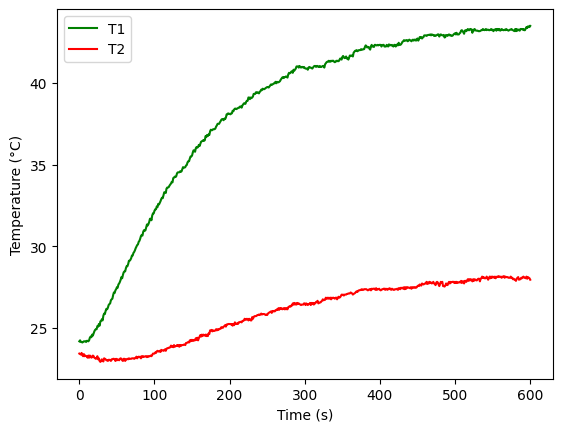

In [17]:
plt.plot(time, T1,'g-', label='T1')
plt.plot(time, T2,'r-', label='T2')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


On peut également mettre cette courbe sous la forme d'un dataframe et l'enregistrer comme un fichier excel (.csv également possible)

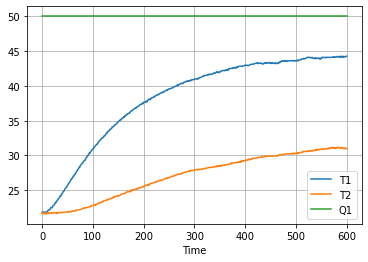

In [22]:
import pandas as pd

# Creation du dataframe
df = pd.DataFrame([time, T1, T2, Q1]).T
df.columns = ['Time', 'T1', 'T2', 'Q1']
df = df.set_index('Time')

# Affichage du dataframe
df.plot(grid=True)

# Enregistrement sous la forme d'un ficher excel ou csv
df.to_csv('Step_Test_Data.csv')
